<a href="https://colab.research.google.com/github/james-t-little/cnn_diss_repo/blob/main/code/tf_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, concatenate, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
IMG_SIZE = 512

drive.mount('/content/drive')

path = '/content/drive/MyDrive/dissertation_seg_data'

input_path = os.path.join(path,"input_resize_patches/")

mask_path = os.path.join(path,"mask_resize_patches/")

Mounted at /content/drive


In [3]:
def parse_image(image_path):
    mask_path = tf.strings.regex_replace(image_path, "image", "labels")
    mask_path = tf.strings.regex_replace(mask_path, "input_resize_patches", "mask_resize_patches")

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)

    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image' : image, 'segmentation_mask': mask}

In [4]:
train_dataset = tf.data.Dataset.list_files(input_path + "*.png")

train_size = 0.8 * train_dataset.cardinality().numpy()

validation_size = 0.1 * train_dataset.cardinality().numpy()

train_ds = train_dataset.take(train_size)

extra = train_dataset.skip(train_size)  

val_ds = extra.take(validation_size)

test_ds = extra.skip(validation_size)

train_ds = train_ds.map(parse_image)

test_ds = test_ds.map(parse_image)

val_ds = val_ds.map(parse_image)

In [5]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    return image, mask

def load_image_train(datapoint):

    image = datapoint['image']
    mask = datapoint['segmentation_mask']

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image, mask = normalize(image, mask)

    return image, mask

def load_image_test(datapoint):

    image = datapoint['image']
    mask = datapoint['segmentation_mask']

    image, mask = normalize(image, mask)

    return image, mask

In [6]:
BATCH_SIZE = 8

BUFFER_SIZE = 1000

dataset = {"train": train_ds, "test": test_ds, "val": val_ds}

dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(buffer_size=BUFFER_SIZE, seed=47).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(load_image_test).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['test'] = dataset['test'].map(load_image_test).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [7]:
def convolutional_layer_block(previous_layer, filter_size, kernel):
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(previous_layer)
        x = Dropout(0.05)(x)
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

def u_net(img_shape, n_classes):
    inputs = Input(shape=img_shape)
    previous_layer = inputs

    concatenate_link = []
    for filter_size in [32, 64, 128, 256]:
        x = convolutional_layer_block(previous_layer, filter_size, (3,3))
        concatenate_link.append(x)
        x = MaxPooling2D((2, 2))(x)
        previous_layer = x

    concatenate_link = list(reversed(concatenate_link))
    x = convolutional_layer_block(previous_layer, 512, (3,3))
    previous_layer = x

    for count,filter_size in enumerate([256, 128, 64, 32]):
        x = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same')(previous_layer)
        x = concatenate([x, concatenate_link[count]], axis = 3)
        convolutional_layer_block(x, filter_size, (3,3))
        previous_layer = x

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, kernel_size=(1, 1), activation=activation)(previous_layer)

    return Model(inputs=inputs, outputs=outputs)

model = u_net((IMG_SIZE, IMG_SIZE, 3), n_classes = 255)

keras.backend.clear_session()

In [8]:
model.compile(optimizer=Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [9]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(("/content/drive/MyDrive/"+"lr01_e10_bs8.h5"), verbose = 1, save_best_only=True, save_weights_only=True)]

In [10]:
EPOCHS = 1

length_data = train_ds.cardinality().numpy()

length_val = val_ds.cardinality().numpy()

STEPS_PER_EPOCH = length_data // BATCH_SIZE

VALIDATION_STEPS = length_val // BATCH_SIZE

In [11]:
model_history = model.fit(dataset['train'], epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=dataset['val'], callbacks = callbacks)

938/938 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.5926
Epoch 1: val_loss improved from inf to 0.96219, saving model to /content/drive/MyDrive/lr01_e10_bs8.h5
938/938 [==============================] - 1893s 1s/step - loss: 1.1237 - accuracy: 0.5926 - val_loss: 0.9622 - val_accuracy: 0.6671


In [12]:
model.save("/content/drive/MyDrive/"+"lr01_e10_bs8.h5")

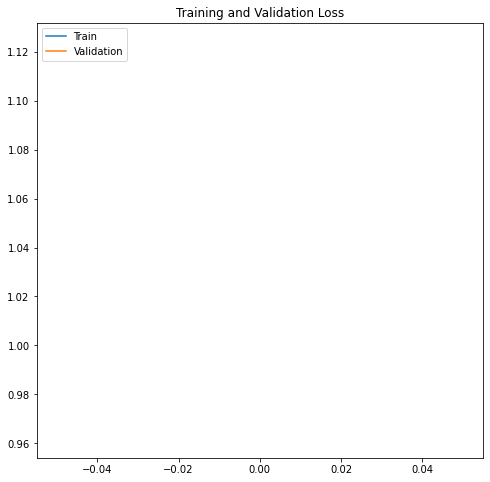

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

def plot_training_data(graph_name, train_metric, val_metric):
    plt.figure(figsize = (8,8))
    plt.plot(train_metric, label = "Train")
    plt.plot(val_metric, label = "Validation")
    plt.title(graph_name)
    plt.legend(loc="upper left")
    plt.show()

plot_training_data("Training and Validation Loss", loss, val_loss)

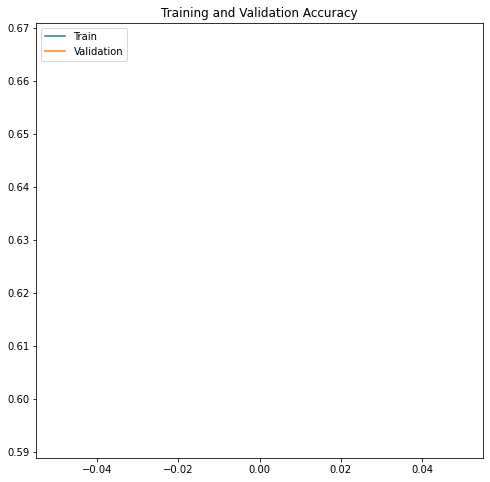

In [14]:
plot_training_data("Training and Validation Accuracy", accuracy, val_accuracy)

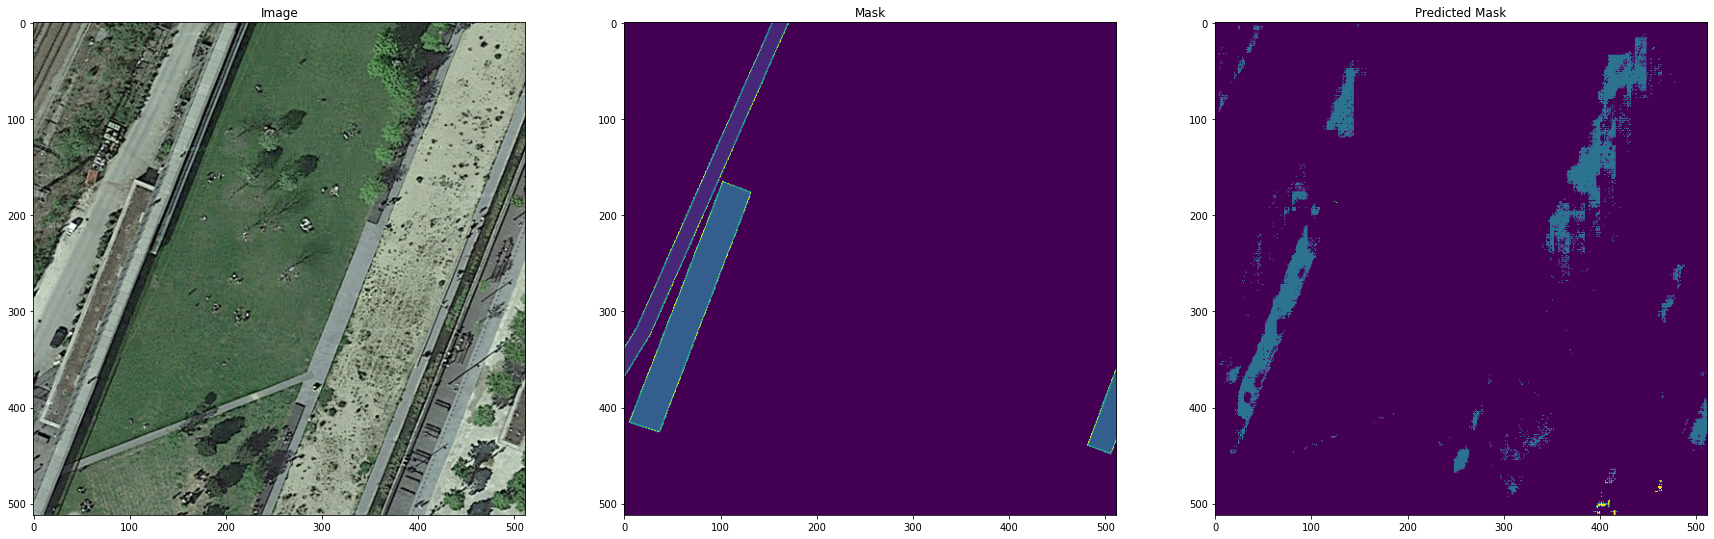

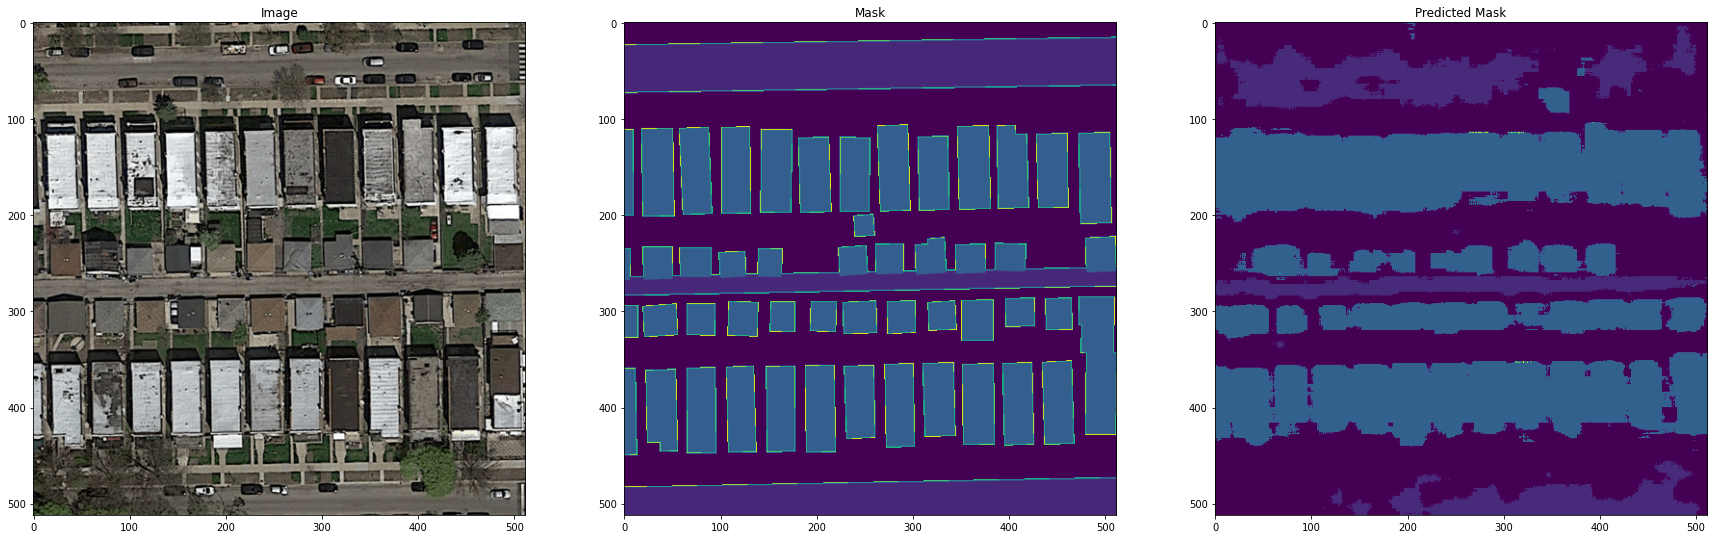

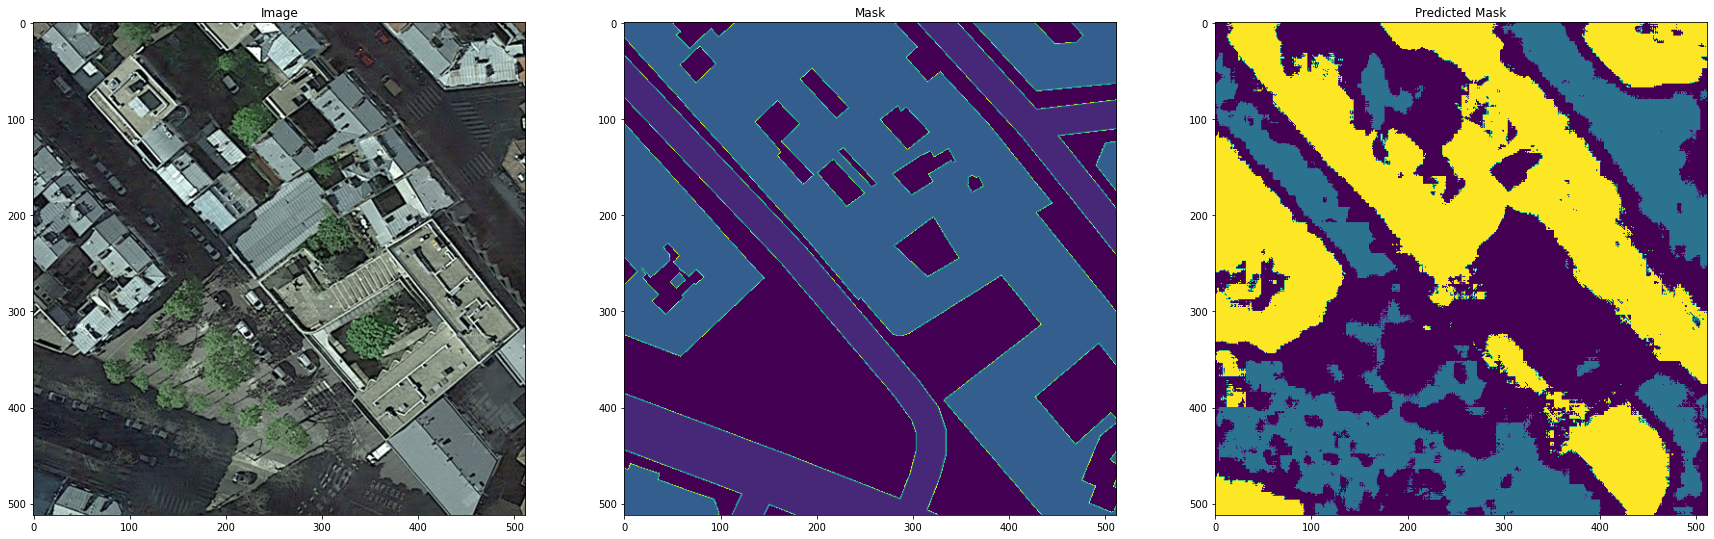

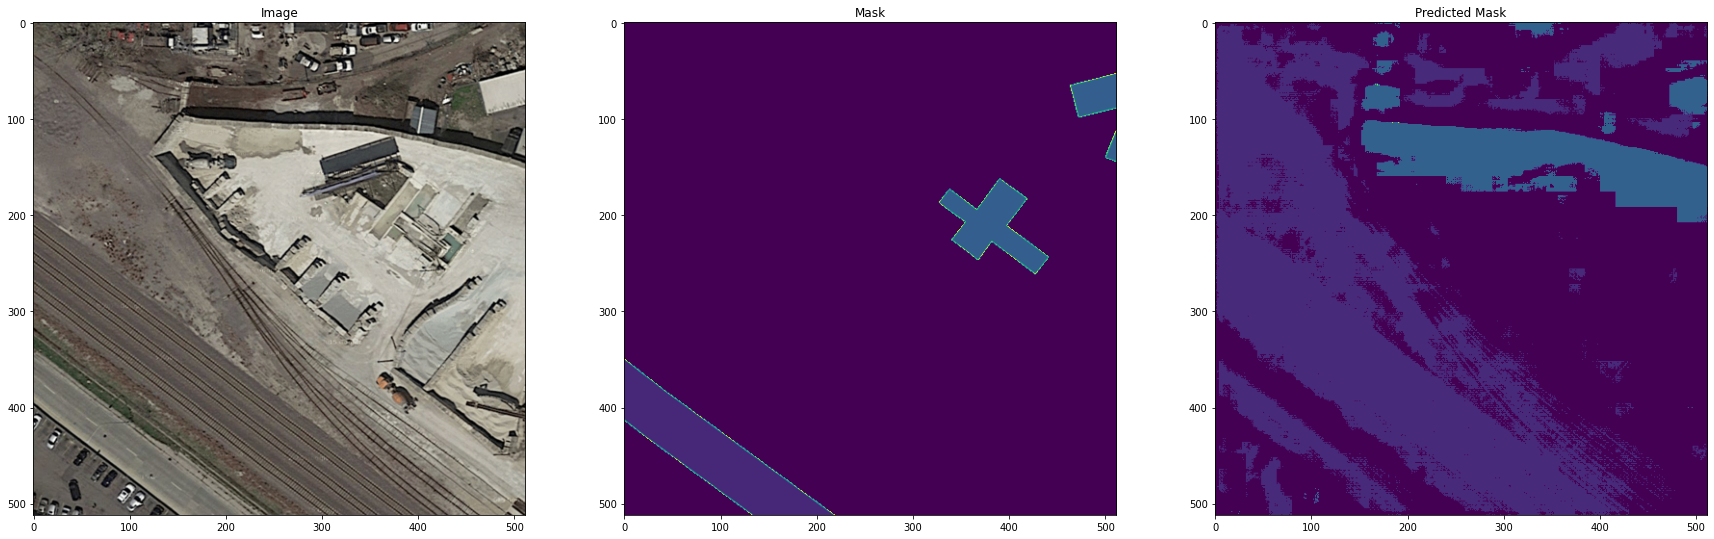

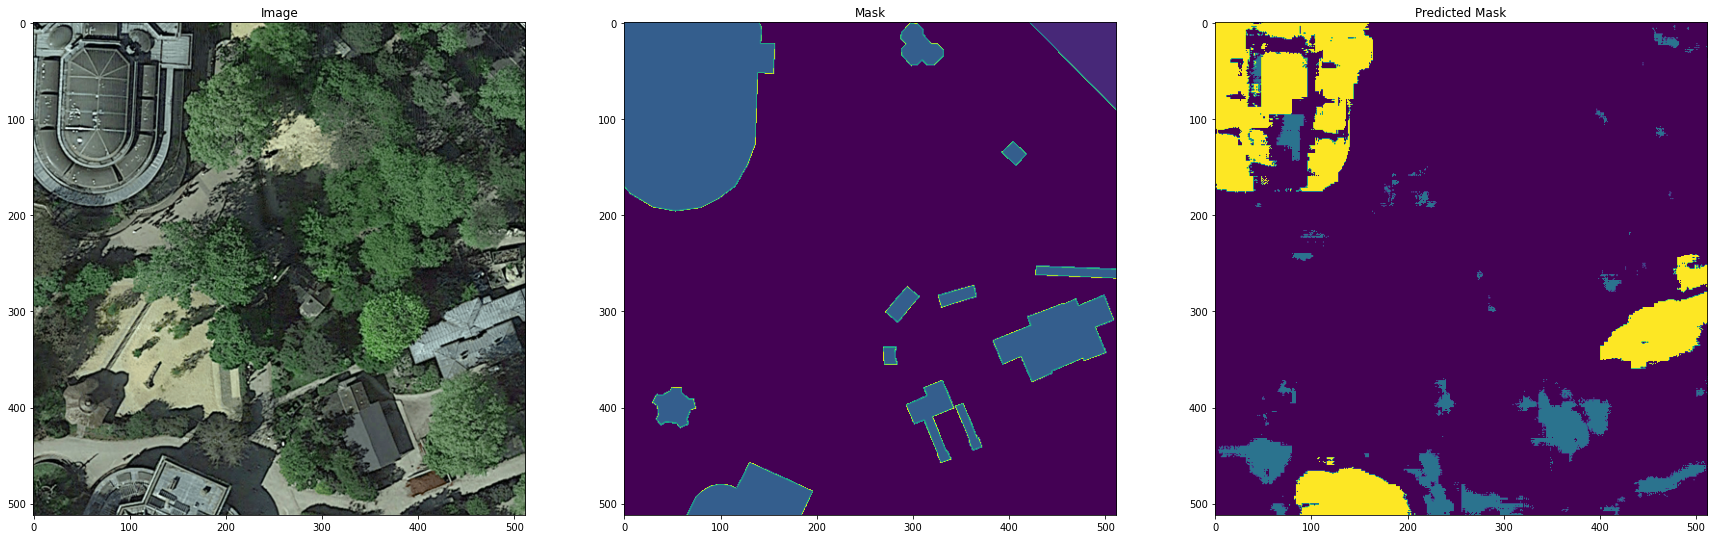

In [21]:
def display_predictions(img,mask,pred_mask):
    plt.figure(figsize=(30,30))
    plt.subplot(1,3,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask))
    plt.title('Predicted Mask')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

for image, mask in dataset['test'].take(1):
    for img_idx in range(5):
        pred_mask = model.predict(image)
        pred_mask = create_mask(pred_mask[img_idx])
        display_predictions(image[img_idx], mask[img_idx], pred_mask)